# Imports

In [7]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
pd.set_option('float_format', '{:f}'.format)
pd.set_option('display.max_rows', 30)
pd.set_option('display.max_columns', 99)
import pandas_bokeh
pandas_bokeh.output_file("data/bokeh_output.html")

import polygon_df as pdf
import polygon_ds as pds
import polygon_s3 as ps3

import bar_samples as bs
import bar_labels as bl
import bar_workflow as bw
import utils_filters as ft

import matplotlib as mpl
from matplotlib import style
style.use('fivethirtyeight')
mpl.rcParams['figure.figsize'] = [20, 7]

# df.style.background_gradient(cmap='coolwarm', axis=None, vmin=-1, vmax=1)  # 'Blues', 'coolwarm', 'RdBu_r' & 'BrBG' are other good diverging colormaps
# pd.set_option('precision', 2)
# .plot_bokeh(sizing_mode="scale_height")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Sample tick dates

In [3]:
# set sampling params
symbol = 'VTI'
start_date = '2020-11-01'
end_date = '2020-11-05'
max_sec = 1800

thresh = {
    # max thresholds
    'renko_return': 'jma_return',
    'renko_reveral_multiple': 2,
    'renko_range_frac': 20,
    'max_duration_sec': max_sec,
    # min thresholds
    'min_duration_sec': 10,
    'min_tick_count': 30,
    # label params
    'horizon_mins': max_sec/60,
    'reward_ratios': list(np.arange(2.5, 11, 0.5)),
}

daily_stats_df = bw.get_symbol_vol_filter(symbol, start_date, end_date)

results = []
for row in daily_stats_df.itertuples():
    if 'range_jma_lag' in daily_stats_df.columns:
        rs = max(row.range_jma_lag / thresh['renko_range_frac'], row.vwap_jma_lag * 0.0005)
        thresh.update({'renko_size': rs})
        thresh.update({'risk_level': rs})

    bars = bw.bar_workflow(
        symbol=symbol, 
        date=row.date,
        thresh=thresh,
    )
    results.append(bars)

VTI 2020-11-02 trying to get data from local file...
VTI 2020-11-03 trying to get data from local file...
VTI 2020-11-04 trying to get data from local file...
VTI 2020-11-05 trying to get data from local file...


In [14]:
results[2]['bars']

,bar_trigger,open_at,close_at,duration_td,duration_sec,duration_min,price_open,price_close,price_low,price_high,price_range,price_return,price_wq10,price_wq50,price_wq90,price_wq_range,price_wmean,price_wstd,jma_open,jma_close,jma_low,jma_high,jma_range,jma_return,jma_wq10,jma_wq50,jma_wq90,jma_wq_range,jma_wmean,jma_wstd,tick_count,volume,dollars,tick_imbalance,volume_imbalance,dollar_imbalance,label_side,label_outcome,label_rrr,label_outcome_at,label_start_at,label_end_at
0,renko_up,2020-11-04 14:30:00.043434240,2020-11-04 14:30:10.460740608,0 days 00:00:10.417306368,10,0.166667,174.160004,174.449997,174.110001,174.500000,0.389999,0.289993,174.160004,174.160004,174.160004,0.000000,174.161351,0.015427,174.160004,174.403980,174.144966,174.408722,0.263756,0.243976,174.160004,174.160004,174.160004,0.000000,174.161375,0.013381,42,120157,20926705.476044,13,675,117661.204559,long,profit,3.500000,2020-11-04 14:32:51.310663680,2020-11-04 14:30:10.460740608,2020-11-04 15:00:10.460740608
1,renko_up,2020-11-04 14:30:10.499878400,2020-11-04 14:30:53.839874048,0 days 00:00:43.339995648,43,0.716667,174.449997,174.600006,174.160004,174.600006,0.440002,0.150009,174.389999,174.404999,174.500000,0.110001,174.433945,0.049947,174.421888,174.578318,174.326107,174.578318,0.252211,0.156429,174.371646,174.411701,174.499974,0.128327,174.428583,0.050729,186,15747,2746811.324951,26,1857,324027.591705,long,profit,2.500000,2020-11-04 14:32:51.472313088,2020-11-04 14:30:53.839874048,2020-11-04 15:00:53.839874048
2,renko_up,2020-11-04 14:30:55.171220736,2020-11-04 14:31:42.850409472,0 days 00:00:47.679188736,47,0.783333,174.580002,174.800003,174.470001,174.800003,0.330002,0.220001,174.500000,174.520004,174.630005,0.130005,174.540097,0.048496,174.583075,174.745074,174.471840,174.745074,0.273234,0.161999,174.500000,174.524153,174.605044,0.105044,174.537737,0.043190,193,19469,3398121.146042,-18,-3244,-565594.887329,neutral,neutral,0.000000,2020-11-04 14:35:29.494622720,2020-11-04 14:31:42.850409472,2020-11-04 15:01:42.850409472
3,renko_up,2020-11-04 14:31:42.854143744,2020-11-04 14:32:49.027558144,0 days 00:01:06.173414400,66,1.100000,174.695007,174.899994,174.580002,174.899994,0.319992,0.204987,174.645004,174.740005,174.859406,0.214401,174.747138,0.069295,174.738127,174.892713,174.625087,174.892713,0.267626,0.154586,174.664137,174.738505,174.857397,0.193260,174.748861,0.068538,188,28948,5058580.162399,-1,-4564,-796897.265762,short,profit,-8.000000,2020-11-04 14:37:56.061323008,2020-11-04 14:32:49.027558144,2020-11-04 15:02:49.027558144
4,renko_down,2020-11-04 14:32:49.029848576,2020-11-04 14:34:56.108770048,0 days 00:02:07.078921472,127,2.116667,174.899994,174.550003,174.550003,175.000000,0.449997,-0.349991,174.789993,174.880005,174.979996,0.190002,174.887600,0.075313,174.896698,174.584409,174.584409,175.000000,0.415591,-0.312289,174.790439,174.875077,174.977016,0.186576,174.887623,0.072268,319,36533,6389168.692688,1,1252,219116.538055,short,profit,-6.000000,2020-11-04 14:37:56.317147904,2020-11-04 14:34:56.108770048,2020-11-04 15:04:56.108770048
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86,renko_down,2020-11-04 20:35:30.560556288,2020-11-04 20:42:54.897594624,0 days 00:07:24.337038336,444,7.400000,176.000000,175.679993,175.679993,176.029999,0.350006,-0.320007,175.750000,175.794998,175.940002,0.190002,175.810529,0.071521,175.992921,175.688417,175.688417,176.020002,0.331585,-0.304504,175.750000,175.791610,175.947690,0.197690,175.810036,0.070255,802,87582,15397837.788773,126,32667,5742893.359085,long,profit,3.000000,2020-11-04 20:54:55.590926848,2020-11-04 20:42:54.897594624,2020-11-04 21:12:54.897594624
87,renko_up,2020-11-04 20:42:54.908862976,2020-11-04 20:46:54.469526272,0 days 00:03:59.560663296,239,3.983333,175.660004,176.000000,175.589996,176.000000,0.410004,0.339996,175.699997,175.779999,175.869995,0.169998,175.784178,0.0613

In [4]:
out = bw.process_bar_dates(
    daily_vol_df=daily_stats_df,
    bar_dates=results,
    imbalance_thresh=0.95,
)

TypeError: string indices must be integers

In [5]:
nbar = 2

<AxesSubplot:xlabel='date_time'>

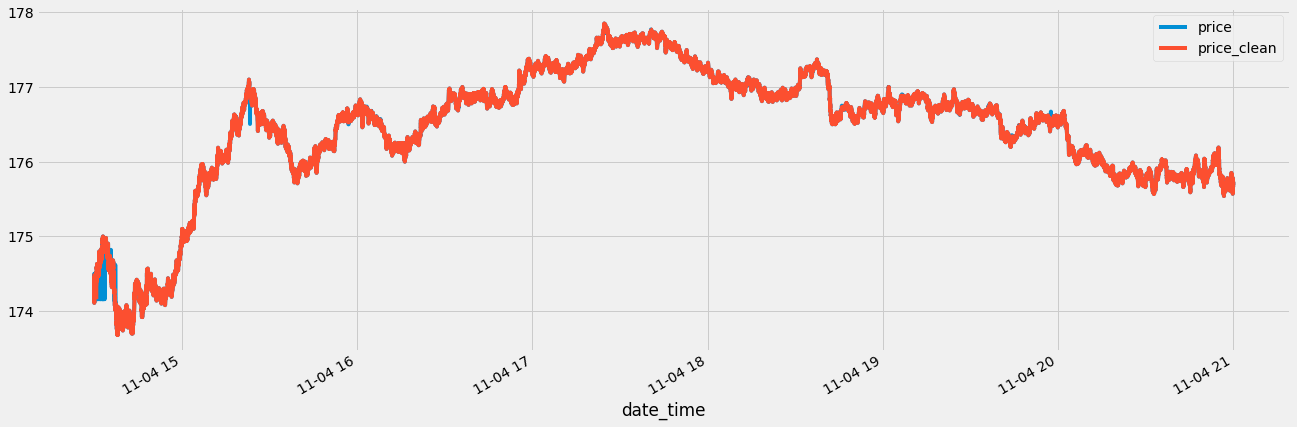

In [8]:
results[nbar]['ticks'].set_index('date_time')[['price', 'price_clean']].plot()

<AxesSubplot:xlabel='date_time'>

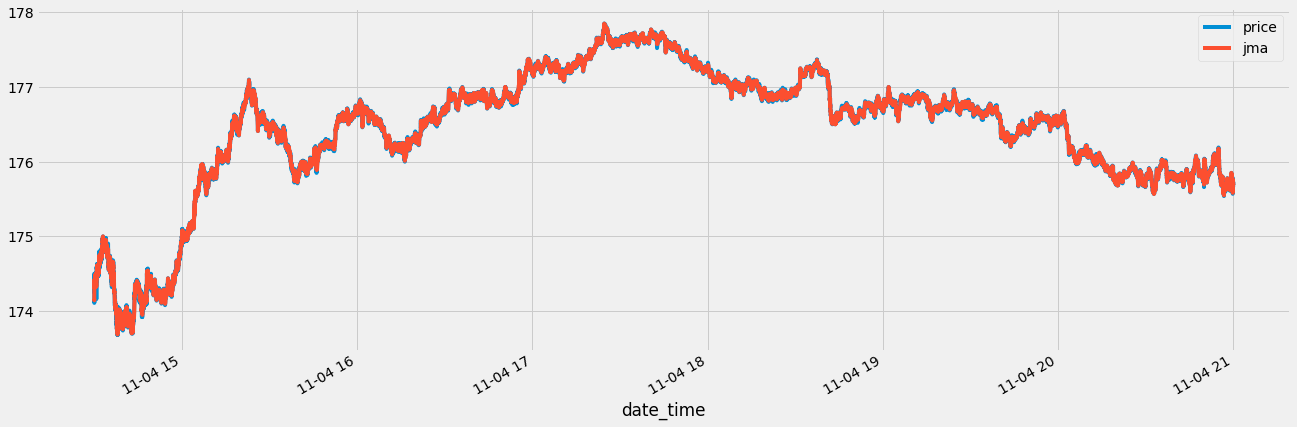

In [11]:
results[nbar]['ticks'][results[nbar]['ticks'].status=='clean'].set_index('date_time')[['price', 'jma']].plot()

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

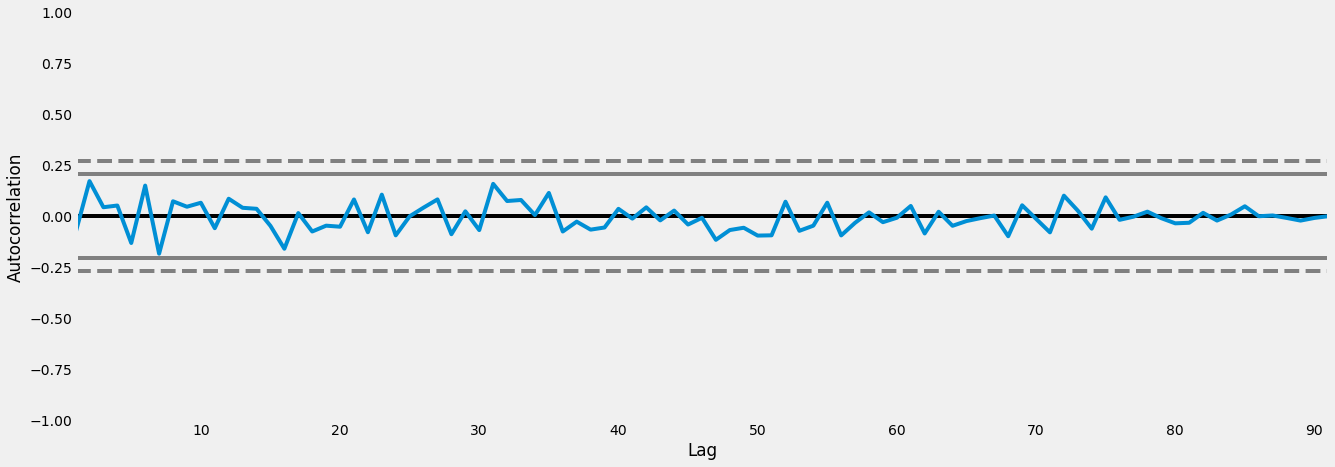

In [10]:
pd.plotting.autocorrelation_plot(results[nbar]['bars'].jma_return)

# ixs = 0
# ixe = ixs+1000
# # ixs = 281
# # ixe = ixs+200

# ticks2_df[ticks2_df.status=='clean'].loc[ixs:ixe, ['price', 'jma']].plot()
# ticks2_df[ticks2_df.status=='clean'].loc[ixs:ixe, ['date_time', 'price', 'jma']].set_index('date_time').plot()

# ticks2_df[ticks2_df.status=='clean'].set_index('date_time').between_time('14:25:00', '14:45:00')[['price', 'jma']].plot()
# # .plot_bokeh(sizing_mode="scale_height")

# Label Bars

In [ ]:
results[nbar]['bars'].label_outcome.value_counts() / results[nbar]['bars'].shape[0]

In [ ]:
len(results[nbar]['bars'][abs(results[nbar]['bars'].label_rrr) >= 2.5]) / results[nbar]['bars'].shape[0]

In [ ]:
(results[nbar]['bars'].label_outcome_at - results[nbar]['bars'].close_at).describe(percentiles=[.2, .8, .95])

In [ ]:
results[nbar]['bars'].label_rrr.hist(bins=30)

In [ ]:
# labeled_bars_df[['jma_wq10', 'jma_wq90']].plot()
results[nbar]['bars'][['jma_high', 'jma_low','jma_close']].plot()
# labeled_bars_df.set_index('close_at')[['jma_high','jma_low', 'jma_close']].plot()

In [ ]:
results[nbar]['bars']['label_rrr'].plot()
# labeled_bars_df.set_index('close_at')['label_rrr'].plot()